In [2]:
# imports pytorch
import torch
import time
import copy
from datetime import datetime
import glob
import pandas as pd
import seaborn as sns
from IPython.display import Image, display
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image as Img
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import torch.backends
import zipfile
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
torch.backends.cudnn.enabled = False
#CUDA_LAUNCH_BLOCKING=1.

XLA_USE_BF16=1

In [3]:
archivo_train = r"./data/train.csv"
archivo_test = r"./data/test.csv"
dir_imagenes = r"./data/all_imgs/"
model_dir = r"./data/"
torch.cuda.max_memory_allocated(0)

drive = r"./data/"
archivo_train = drive+r"train.csv"
archivo_test = drive+r"test.csv"
dir_imagenes = drive+r"all_imgs/"

In [4]:
dataset : pd.DataFrame = pd.read_csv(archivo_train, index_col=0)

In [5]:
torch.manual_seed(17)

In [6]:
class ComidasDataset(Dataset):
    def __init__(self, annotations_file : pd.DataFrame, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_path = self.img_labels.iloc[idx, 0]
        img_path = dir_imagenes + os.path.basename(img_path)
        image = Img.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [7]:
seleccionados = dataset.query('label == 6 or label == 0 or label == 4 or label == 7')
seleccionados

,path_img,label
idx_train,,
0,all_imgs/bc7696f4-1460-4d0b-a63d-f84b3be4da0f....,0
2,all_imgs/51df0f29-758b-4741-ab74-a0ff8e21c044....,4
3,all_imgs/f61b81d3-3b79-4162-b4d6-4f1b39518c4c....,0
4,all_imgs/b21e0668-bd09-4794-9e90-da8ecffc4c1c....,0
5,all_imgs/f74f3501-44a6-4fc5-8f5f-01abe6842420....,0
...,...,...
11192,all_imgs/6b28a0bb-c58a-48f7-bce2-198403b1bd55....,0
11194,all_imgs/74441f96-e19f-487a-b506-75861f6e4ae4....,0
11196,all_imgs/b93165ab-a87d-4ee1-8360-9b9728a3fc4b....,6


/tmp/ipykernel_107313/180658003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seleccionados['label'] = seleccionados['label'].apply(lambda x: int(1) if x == 6 else int(2) if x==4 else int(3) if x==7 else x)


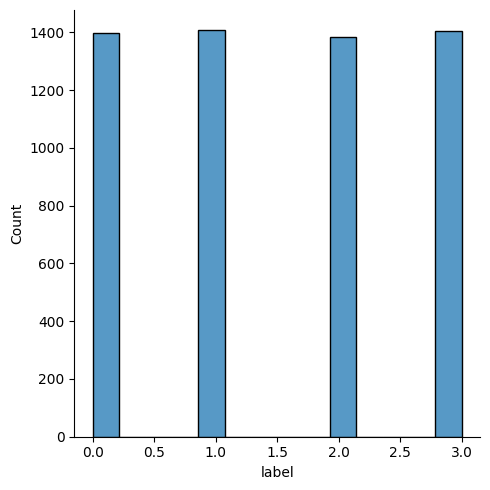

In [8]:
seleccionados['label'] = seleccionados['label'].apply(lambda x: int(1) if x == 6 else int(2) if x==4 else int(3) if x==7 else x)
sns.displot(seleccionados.label)
plt.show()

In [11]:
# Estratificar los dataset para que comprenda todas las clases por igual.
train_dataset, val_dataset = train_test_split(
    seleccionados, test_size=0.2, random_state=17)

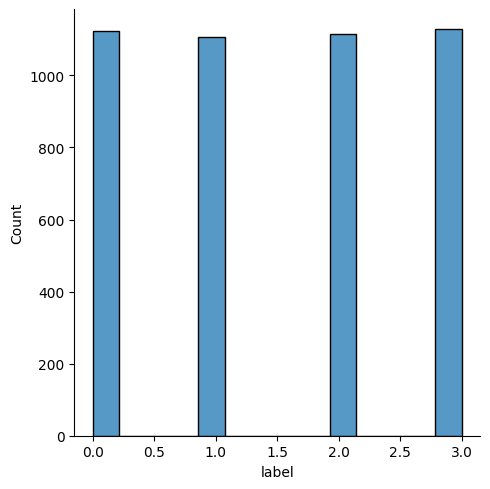

In [12]:
sns.displot(train_dataset.label)
plt.show()

In [13]:
transform = transforms.Compose([
    transforms.RandomCrop(256),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    transforms.ToTensor()
])

transform_val = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor()
])

transform_cifar10 = transforms.Compose([transforms.Resize((300,300)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])

In [14]:
dat_train = ComidasDataset( train_dataset, transform=transform )
dat_test = ComidasDataset( val_dataset, transform=transform_val )

In [15]:
""" Muy importante:
    Aqui se decide el batch size, que despues se incluye en la capa lineal
"""
train_dataloader = DataLoader(dat_train, batch_size=40, shuffle=True)
test_dataloader = DataLoader(dat_test, batch_size=40, shuffle=True)

In [16]:
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [14]:
from torchvision import models
def CNN_Model(pretrained=True):
    class_names = ["Burger","Bocata","Perrito","Patatas"]
    model = models.resnet101(pretrained=False) 
    #num_ftrs = model.classifier.in_features
    #model.classifier = nn.Linear(num_ftrs, len(class_names))
    device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device) 
    return model

model = CNN_Model(pretrained=True)

In [16]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
# Funciones base sacadas de https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
def train_loop(dataloader, model, loss_fn, optimizer):
    best_accuracy = 0.0
    
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = xm.xla_device()
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model = model.to(device)
    size = len(dataloader.dataset)

    for batch, (images, label) in enumerate(dataloader):
        # get the inputs
        #X = Variable(torch.tensor(images))
        images = images.to(device)
        y = Variable(label.to(device))

        # Compute prediction and loss
        pred = model(images)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(batch)
        # print cada 2 batches = 2 * 1024 = 2048 imagenes
        if batch % 5 == 0:
            loss, current = loss.item(), (batch + 1) * len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = xm.xla_device()

    # matriz de confusion
    y_pred = []
    y_true = []


    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            '''
            output = (torch.max(torch.exp(pred), 1)[1]).data.cpu().numpy()

            y_pred.extend(output) # Save Prediction
        
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth
            '''
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    '''
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion")
    print(conf_matrix)
    '''

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [18]:
from torch.optim import Adam, lr_scheduler

learning_rate = 0.01
max_lr = 0.1
epochs=100

loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) # Learning Scheduler

scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
44549160


In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
                    
            if phase == 'train':
                scheduler.step()
                print("Learnin rate =",optimizer.param_groups[0]["lr"])

            # Estaba 1 mas a al der
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [20]:

# base_model = model.load_state_dict(torch.load(drive+f"model_14marzo_parcial__.pth"))

In [21]:

dataloaders = {"train":train_dataloader, "val":test_dataloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
base_model = train_model(model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=200)

Epoch 1/200
----------
Learnin rate = 0.01
train Loss: 0.5574 | train Accuracy: 0.0624
val Loss: 14163.9333 | val Accuracy: 0.2466 | Kappa Score: -0.0000
Val loss Decreased from inf to 14163.9333 
Saving Weights... 

Epoch 2/200
----------
Learnin rate = 0.01
train Loss: 0.4033 | train Accuracy: 0.0662
val Loss: 1.4643 | val Accuracy: 0.2681 | Kappa Score: 0.0012
Val loss Decreased from 14163.9333 to 1.4643 
Saving Weights... 

Epoch 3/200
----------
Learnin rate = 0.01
train Loss: 0.3552 | train Accuracy: 0.0680
val Loss: 61.1493 | val Accuracy: 0.2609 | Kappa Score: 0.0114

Epoch 4/200
----------
Learnin rate = 0.01
train Loss: 0.3481 | train Accuracy: 0.0774
val Loss: 1.5778 | val Accuracy: 0.3646 | Kappa Score: 0.1538

Epoch 5/200
----------
Learnin rate = 0.005
train Loss: 0.3338 | train Accuracy: 0.0872
val Loss: 1.4665 | val Accuracy: 0.3351 | Kappa Score: 0.1084

Epoch 6/200
----------
Learnin rate = 0.005
train Loss: 0.3144 | train Accuracy: 0.0975
val Loss: 1.2314 | val Accur

In [20]:
model = torch.load(drive+r"ModeloFinalParcial.pt").to(device)

In [21]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        y = Variable(labels.to(device))
        
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        #labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [22]:
# Calcular la matriz de confusión
labels = ["Burger","Bocata","Hotdog","Patatas"]
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[259  16   0   0]
 [ 19 259  18   3]
 [  2  24 232  11]
 [  0   0   4 272]]


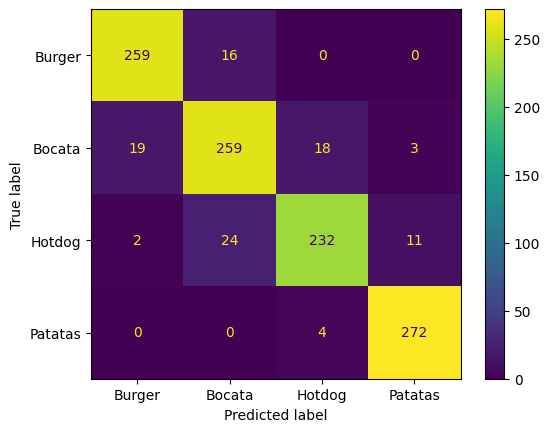

In [23]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot()

plt.show()

In [28]:
print(classification_report(y_true, y_pred,target_names=labels))



              precision    recall  f1-score   support

      Burger       0.97      0.99      0.98       275
      Bocata       0.96      0.98      0.97       299
      Hotdog       0.98      0.95      0.97       269
     Patatas       1.00      1.00      1.00       276

    accuracy                           0.98      1119
   macro avg       0.98      0.98      0.98      1119
weighted avg       0.98      0.98      0.98      1119



In [29]:
torch.save(model.state_dict(), drive+f"model_16marzo_burgerbocatahotdogfries_trans.pth")

In [16]:
PATH = drive+"model_16marzo_burgerbocatahotdogfries_trans.pth"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
PATH = drive+r"ModeloFinalParcial.pt"
torch.save(model, PATH)